In [3]:

import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter


import os
import re


import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora 
from gensim.models.ldamulticore import LdaMulticore
#from gensim.models import LdaMulticore
from gensim.corpora import Dictionary
import pyLDAvis.gensim

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
from nltk.stem import SnowballStemmer


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier, SGDRegressor 


from sklearn.ensemble import RandomForestClassifier


from sklearn.neighbors import NearestNeighbors


from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder


import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM, Embedding, Conv1D, MaxPooling1D, Activation
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical, get_file
from tensorflow.keras.preprocessing import sequence #one_hot, hashing_trick
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, defaultdict
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/google/protobuf/descriptor.py:47: DeprecationWarning: Using or importing the ABCs from 'collectio

In [4]:
reviews_df = pd.read_csv('review.csv', engine='python', error_bad_lines=False)
business_df = pd.read_csv('business.csv')

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (56,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6.0,1.0,0.0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0.0,0.0,0.0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3.0,0.0,0.0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0.0,0.0,0.0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7.0,0.0,0.0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [6]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
business_df.head()


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,attributes.GoodForKids,attributes.RestaurantsReservations,attributes.GoodForMeal,attributes.BusinessParking,attributes.Caters,attributes.NoiseLevel,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.RestaurantsPriceRange2,attributes.OutdoorSeating,attributes.BikeParking,attributes.Ambience,attributes.HasTV,attributes.WiFi,attributes.Alcohol,attributes.RestaurantsAttire,attributes.RestaurantsGoodForGroups,attributes.RestaurantsDelivery,hours.Monday,hours.Tuesday,hours.Wednesday,hours.Thursday,hours.Friday,hours.Saturday,hours.Sunday,attributes.BusinessAcceptsCreditCards,attributes,attributes.BusinessAcceptsBitcoin,attributes.ByAppointmentOnly,attributes.AcceptsInsurance,attributes.Music,attributes.GoodForDancing,attributes.CoatCheck,attributes.HappyHour,attributes.BestNights,attributes.WheelchairAccessible,attributes.DogsAllowed,attributes.BYOBCorkage,attributes.DriveThru,attributes.Smoking,attributes.AgesAllowed,attributes.HairSpecializesIn,attributes.Corkage,attributes.BYOB,attributes.DietaryRestrictions,attributes.Open24Hours,attributes.RestaurantsCounterService
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,"Golf, Active Life",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"Specialty Food, Restaurants, Dim Sum, Imported...",NaN,True,True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",True,u'loud',True,True,2,False,False,"{'romantic': False, 'intimate': False, 'classy...",False,u'no',u'full_bar',u'casual',True,False,9:0-0:0,9:0-0:0,9:0-0:0,9:0-0:0,9:0-1:0,9:0-1:0,9:0-0:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"Sushi Bars, Restaurants, Japanese",NaN,True,True,"{'dessert': False, 'latenight': False, 'lunch'...","{'garage': False, 'street': False, 'validated'...",False,u'average',True,True,2,False,True,"{'romantic': False, 'intimate': False, 'touris...",True,u'no',u'beer_and_wine','casual',True,False,17:30-21:30,NaN,17:30-21:30,17:30-21:30,17:30-22:0,17:30-22:0,17:30-21:0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,"Insurance, Financial Services",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,8:0-17:0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"Plumbing, Shopping, Local Services, Home Servi...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,7:0-23:0,True,NaN,False,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
print(reviews_df.shape)

(6685902, 9)


In [8]:
reviews_df = reviews_df.drop(columns = {'review_id', 'date', 'useful', 'funny', 'cool'})
business_df = business_df.drop(columns = {'name', 'address', 'postal_code', 'latitude', 'longitude', 'is_open', 'categories', 'city', 'state', 'review_count','hours','attributes.GoodForKids', 'attributes.RestaurantsReservations', 'attributes.GoodForMeal', 'attributes.BusinessParking', 'attributes.Caters', 'attributes.NoiseLevel', 'attributes.RestaurantsTableService', 'attributes.RestaurantsTakeOut', 'attributes.RestaurantsPriceRange2', 'attributes.OutdoorSeating','attributes.BikeParking', 'attributes.Ambience', 'attributes.HasTV', 'attributes.WiFi', 'attributes.Alcohol', 'attributes.RestaurantsAttire', 'attributes.RestaurantsGoodForGroups', 'attributes.RestaurantsDelivery', 'hours.Monday', 'hours.Tuesday', 'hours.Wednesday', 'hours.Thursday', 'hours.Friday', 'hours.Saturday', 'hours.Sunday','attributes.BusinessAcceptsCreditCards','attributes','attributes.BusinessAcceptsBitcoin','attributes.ByAppointmentOnly','attributes.AcceptsInsurance','attributes.Music','attributes.GoodForDancing','attributes.CoatCheck','attributes.HappyHour','attributes.BestNights','attributes.WheelchairAccessible','attributes.DogsAllowed','attributes.BYOBCorkage','attributes.DriveThru','attributes.Smoking','attributes.AgesAllowed','attributes.HairSpecializesIn','attributes.Corkage','attributes.BYOB','attributes.DietaryRestrictions','attributes.Open24Hours','attributes.RestaurantsCounterService'})
business_df = business_df.rename(columns={'stars' : 'rating'})

In [9]:
print(reviews_df.shape)
reviews_df.head()

(6685902, 4)


,user_id,business_id,stars,text
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,Total bill for this horrible service? Over $8G...
1,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,I *adore* Travis at the Hard Rock's new Kelly ...
2,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,I have to say that this office really has it t...
3,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,Went in for a lunch. Steak sandwich was delici...
4,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,Today was my second out of three sessions I ha...


## Merging the DataFrames

In [10]:
''' Merging the DataFrames '''
reviews_df = pd.merge(reviews_df, business_df, how='inner')

In [11]:
print(reviews_df.shape)
reviews_df.head()

(6685900, 5)


,user_id,business_id,stars,text,rating
0,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,Total bill for this horrible service? Over $8G...,2.5
1,RBXSJA372ilErzNwz0jXvQ,ujmEBvifdJM6h6RLv4wQIg,4.0,My family has used this ER four times in the p...,2.5
2,x3brMMbJrAW9PwW5A6YL5w,ujmEBvifdJM6h6RLv4wQIg,1.0,I have never been more disappointed by the car...,2.5
3,Skzdl0sWhW88525a1vr59g,ujmEBvifdJM6h6RLv4wQIg,1.0,"Went in for a broken finger, was asked if I wa...",2.5
4,3Y25VDfnQVcuc33T-U3Z6A,ujmEBvifdJM6h6RLv4wQIg,5.0,My mother was at Mountain View for nearly two ...,2.5


In [12]:
reviews_df.isnull().sum()

user_id        0
business_id    0
stars          0
text           2
rating         0
dtype: int64

In [13]:
df1 = reviews_df[reviews_df.isna().any(axis=1)]

In [14]:
df1

,user_id,business_id,stars,text,rating
3947686,pUKAjAaSMkxiJ1WCIFSsBQ,I7XWtKL1oHohZCtCCyQIog,1.0,NaN,2.0
6103360,v3DIq18Z30KNwyUvBXtXEA,oXoVJ0xKv82cBo9U6oEjlQ,3.0,NaN,3.5


In [15]:
reviews_df= reviews_df.drop([3947686, 6103360])

In [16]:
reviews_df.isnull().sum()

user_id        0
business_id    0
stars          0
text           0
rating         0
dtype: int64

## Tokenize

In [17]:
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import spacy

nlp = spacy.load('en_core_web_lg')

STOPWORDS = set(STOPWORDS).union(set(['in', ' ', '', '\\n', 'strain', 'an', '$', 'got', 'as', 'the', 'it', 'place', '+', 'service', 'time']))

def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/thinc/neural/train.py:7: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from .optimizers import Adam, linear_decay
/Users/maximevacher-materno/anaconda3/lib/python3.7/site-packages/thinc/check.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence, Sized, Iterable, Callable


In [18]:
reviews_df['token'] = reviews_df['text'].apply(tokenize)
reviews_df['token'].head()

# tokenize(reviews_df['text'][0])

# reviews_df['token']= [tokenize(string) for string in reviews_df['text']]

0    [total, horrible, gs, crooks, actually, nerve,...
1    [family, er, times, past, years, past, waiting...
2    [disappointed, care, provided, mountainview, h...
3    [went, broken, finger, asked, pain, stated, fi...
4    [mother, mountain, view, nearly, weeks, surger...
Name: token, dtype: object

In [19]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [20]:
wc = count(reviews_df['token'])

In [21]:
wc.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
279,food,2228704,3389029,1.0,0.010906,0.010906,0.333344
176,good,2207551,3277559,2.0,0.010547,0.021453,0.330180
274,great,2114228,2910705,3.0,0.009367,0.030820,0.316222
194,like,1655986,2378025,4.0,0.007652,0.038472,0.247683
447,ve,1016598,1342149,5.0,0.004319,0.042791,0.152051


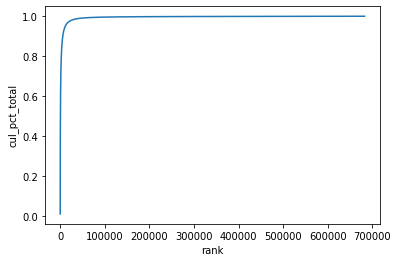

In [22]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [23]:
wc[wc['rank'] <= 20]['cul_pct_total'].max()

0.09225862855056345

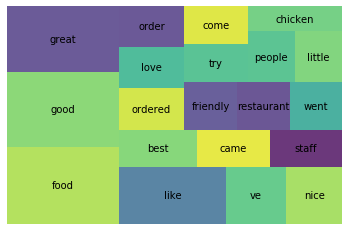

In [24]:
import squarify
import matplotlib.pyplot as plt

wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

## Vector Representation

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(stop_words= 'english')
sparse = tfidf.fit_transform(reviews_df['text'])

In [ ]:
sparse_array = sparse.toarray()

In [1]:
reviews_df_vector = pd.DataFrame(sparse.todense(), columns=tfidf.get_feature_names())
reviews_df_vector.head()

NameError: name 'pd' is not defined

## Elbow Method For Optimal k

In [ ]:
from sklearn.cluster import KMeans 
import tqdm
from tqdm import tqdm

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in tqdm(K):
    km = KMeans(n_clusters=k)
    km = km.fit(reviews_df_vector)
    Sum_of_squared_distances.append(km.inertia_)

In [ ]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

## PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()


# fit on data
pca.fit(reviews_df_vector)

# transform data
B = pca.transform(reviews_df_vector)

## KMeans

In [ ]:
from sklearn.cluster import KMeans 

# Number of cluster
kmeans = KMeans(n_clusters=2)

#fit Model
kmeans.fit(B)

# Labels
label = kmeans.labels_

# Coordinate of cluster center to variable centers
center =kmeans.cluster_centers_

print(label)